In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold
import xgboost as xgb
from xgboost import XGBRegressor

### Read in the data

- timestamp - A timestamp for the minute covered by the row.
- Asset_ID - An ID code for the cryptoasset.
- Count - The number of trades that took place this minute.
- Open - The USD price at the beginning of the minute.
- High - The highest USD price during the minute.
- Low - The lowest USD price during the minute.
- Close - The USD price at the end of the minute.
- Volume - The number of cryptoasset units traded during the minute.
- VWAP - The volume weighted average price for the minute.
- Target - 15 minute residualized returns. 

In [4]:
crypto_df = pd.read_csv('Resources/train.csv')
crypto_df.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.5800,2399.5000,2357.1400,2374.5900,19.233005,2373.116392,-0.004218
1,1514764860,0,5.0,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399
2,1514764860,1,229.0,13835.1940,14013.8000,13666.1100,13850.1760,31.550062,13827.062093,-0.014643
3,1514764860,5,32.0,7.6596,7.6596,7.6567,7.6576,6626.713370,7.657713,-0.013922
4,1514764860,7,5.0,25.9200,25.9200,25.8740,25.8770,121.087310,25.891363,-0.008264


In [5]:
asset_df = pd.read_csv('Resources/asset_details.csv')
asset_df

,Asset_ID,Weight,Asset_Name
0,2,2.397895,Bitcoin Cash
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
3,5,1.386294,EOS.IO
4,7,2.079442,Ethereum Classic
5,6,5.894403,Ethereum
6,9,2.397895,Litecoin
7,11,1.609438,Monero
8,13,1.791759,TRON
9,12,2.079442,Stellar


### Clean the dataset

In [6]:
# check the datatypes and counts of each column
crypto_df.info(show_counts =True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24236806 entries, 0 to 24236805
Data columns (total 10 columns):
 #   Column     Non-Null Count     Dtype  
---  ------     --------------     -----  
 0   timestamp  24236806 non-null  int64  
 1   Asset_ID   24236806 non-null  int64  
 2   Count      24236806 non-null  float64
 3   Open       24236806 non-null  float64
 4   High       24236806 non-null  float64
 5   Low        24236806 non-null  float64
 6   Close      24236806 non-null  float64
 7   Volume     24236806 non-null  float64
 8   VWAP       24236797 non-null  float64
 9   Target     23486468 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 1.8 GB


In [7]:
# double check the missing values in each column 
crypto_df.isnull().sum()

timestamp         0
Asset_ID          0
Count             0
Open              0
High              0
Low               0
Close             0
Volume            0
VWAP              9
Target       750338
dtype: int64

In [8]:
# replace NaN Values with Zeros in Target column
crypto_df["Target"] = crypto_df["Target"].fillna(0)

In [9]:
# show all Rows with NaN Values in VWAP column
# from the output below we can see that all the nan values come from Asset_ID 10
crypto_df[crypto_df["VWAP"].isnull()]

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
15004269,1592173560,10,2.0,501.00,501.00,501.00,501.00,0.0,NaN,0.000000
15004283,1592173620,10,4.0,501.00,501.00,501.00,501.00,0.0,NaN,0.000000
15059232,1592426160,10,2.0,529.77,529.77,529.77,529.77,0.0,NaN,0.007356
15143187,1592823720,10,2.0,503.60,503.60,503.60,503.60,0.0,NaN,-0.005672
15183088,1593008940,10,2.0,484.16,484.16,484.16,484.16,0.0,NaN,-0.004281
15184216,1593013920,10,2.0,480.00,480.00,480.00,480.00,0.0,NaN,0.000000
15184243,1593014040,10,2.0,480.00,480.00,480.00,480.00,0.0,NaN,0.000000
15184309,1593014340,10,6.0,479.07,479.07,479.07,479.07,0.0,NaN,0.000000
15184778,1593016440,10,4.0,478.00,478.00,475.00,478.00,0.0,NaN,0.000000


In [10]:
# when I clean the data, I found a lot of gaps in data, which influence the consecutive of data visualisation 
# to fill the gaps, we can use the .reindex() method for forward filling, filling gaps with the previous valid value
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reindex.html

In [11]:
# I may code these following steps with function define later to fill gaps for each cryptocurrencies
# fill gaps for Bitcoin Cash
bit_cash = crypto_df[crypto_df["Asset_ID"]==2].set_index("timestamp")
bit_cash = bit_cash.reindex(range(bit_cash.index[0],bit_cash.index[-1]+60,60),method='pad')
(bit_cash.index[1:]-bit_cash.index[:-1]).value_counts()

60    1956959
Name: timestamp, dtype: int64

In [12]:
# fill gaps for Binance Coin
bnc = crypto_df[crypto_df["Asset_ID"]==0].set_index("timestamp")
bnc = bnc.reindex(range(bnc.index[0],bnc.index[-1]+60,60),method='pad')
(bnc.index[1:]-bnc.index[:-1]).value_counts()

60    1956959
Name: timestamp, dtype: int64

In [13]:
# fill gaps for Bitcoin 
bit = crypto_df[crypto_df["Asset_ID"]==1].set_index("timestamp")
bit = bit.reindex(range(bit.index[0],bit.index[-1]+60,60),method='pad')
(bit.index[1:]-bit.index[:-1]).value_counts()

60    1956959
Name: timestamp, dtype: int64

In [14]:
# fill gaps for EOS.IO
eos = crypto_df[crypto_df["Asset_ID"]==5].set_index("timestamp")
eos = eos.reindex(range(eos.index[0],eos.index[-1]+60,60),method='pad')
(eos.index[1:]-eos.index[:-1]).value_counts()

60    1956959
Name: timestamp, dtype: int64

In [15]:
# fill gaps for Ethereum Classic
eth_classic = crypto_df[crypto_df["Asset_ID"]==7].set_index("timestamp")
eth_classic = eth_classic.reindex(range(eth_classic.index[0],eth_classic.index[-1]+60,60),method='pad')
(eth_classic.index[1:]-eth_classic.index[:-1]).value_counts()

60    1956959
Name: timestamp, dtype: int64

In [16]:
# fill gaps for Ethereum
eth = crypto_df[crypto_df["Asset_ID"]==6].set_index("timestamp")
eth = eth.reindex(range(eth.index[0],eth.index[-1]+60,60),method='pad')
(eth.index[1:]-eth.index[:-1]).value_counts()

60    1956959
Name: timestamp, dtype: int64

In [17]:
# fill gaps for Litecoin
lit = crypto_df[crypto_df["Asset_ID"]==9].set_index("timestamp")
lit = lit.reindex(range(lit.index[0],lit.index[-1]+60,60),method='pad')
(lit.index[1:]-lit.index[:-1]).value_counts()

60    1956959
Name: timestamp, dtype: int64

In [18]:
# fill gaps for Monero
mon = crypto_df[crypto_df["Asset_ID"]==11].set_index("timestamp")
mon = mon.reindex(range(mon.index[0],mon.index[-1]+60,60),method='pad')
(mon.index[1:]-mon.index[:-1]).value_counts()

60    1956959
Name: timestamp, dtype: int64

In [19]:
### We find that the start dates of these 6 cryptocurrencies are not from the 2018-01-01, so we are not going to 
### include these in our project.
'''
tro = crypto_df[crypto_df["Asset_ID"]==13].set_index("timestamp")
tro = tro.reindex(range(tro.index[0],tro.index[-1]+60,60),method='pad')
(tro.index[1:]-tro.index[:-1]).value_counts()

ste = crypto_df[crypto_df["Asset_ID"]==12].set_index("timestamp")
ste = ste.reindex(range(ste.index[0],ste.index[-1]+60,60),method='pad')
(ste.index[1:]-ste.index[:-1]).value_counts()

car = crypto_df[crypto_df["Asset_ID"]==3].set_index("timestamp")
car = car.reindex(range(car.index[0],car.index[-1]+60,60),method='pad')
(car.index[1:]-car.index[:-1]).value_counts()

iota = crypto_df[crypto_df["Asset_ID"]==8].set_index("timestamp")
iota = iota.reindex(range(iota.index[0],iota.index[-1]+60,60),method='pad')
(iota.index[1:]-iota.index[:-1]).value_counts()

mak = crypto_df[crypto_df["Asset_ID"]==10].set_index("timestamp")
mak = mak.reindex(range(mak.index[0],mak.index[-1]+60,60),method='pad')
(mak.index[1:]-mak.index[:-1]).value_counts()

dog = crypto_df[crypto_df["Asset_ID"]==4].set_index("timestamp")
dog = dog.reindex(range(dog.index[0],dog.index[-1]+60,60),method='pad')
(dog.index[1:]-dog.index[:-1]).value_counts()
'''

'\ntro = crypto_df[crypto_df["Asset_ID"]==13].set_index("timestamp")\ntro = tro.reindex(range(tro.index[0],tro.index[-1]+60,60),method=\'pad\')\n(tro.index[1:]-tro.index[:-1]).value_counts()\n\nste = crypto_df[crypto_df["Asset_ID"]==12].set_index("timestamp")\nste = ste.reindex(range(ste.index[0],ste.index[-1]+60,60),method=\'pad\')\n(ste.index[1:]-ste.index[:-1]).value_counts()\n\ncar = crypto_df[crypto_df["Asset_ID"]==3].set_index("timestamp")\ncar = car.reindex(range(car.index[0],car.index[-1]+60,60),method=\'pad\')\n(car.index[1:]-car.index[:-1]).value_counts()\n\niota = crypto_df[crypto_df["Asset_ID"]==8].set_index("timestamp")\niota = iota.reindex(range(iota.index[0],iota.index[-1]+60,60),method=\'pad\')\n(iota.index[1:]-iota.index[:-1]).value_counts()\n\nmak = crypto_df[crypto_df["Asset_ID"]==10].set_index("timestamp")\nmak = mak.reindex(range(mak.index[0],mak.index[-1]+60,60),method=\'pad\')\n(mak.index[1:]-mak.index[:-1]).value_counts()\n\ndog = crypto_df[crypto_df["Asset_ID"]

In [20]:
# check again to see if there still any missing data left
bit_cash.isnull().sum()

Asset_ID    0
Count       0
Open        0
High        0
Low         0
Close       0
Volume      0
VWAP        0
Target      0
dtype: int64

In [21]:
bnc.isnull().sum()

Asset_ID    0
Count       0
Open        0
High        0
Low         0
Close       0
Volume      0
VWAP        0
Target      0
dtype: int64

In [22]:
bit.isnull().sum()

Asset_ID    0
Count       0
Open        0
High        0
Low         0
Close       0
Volume      0
VWAP        0
Target      0
dtype: int64

In [23]:
eos.isnull().sum()

Asset_ID    0
Count       0
Open        0
High        0
Low         0
Close       0
Volume      0
VWAP        0
Target      0
dtype: int64

In [24]:
eth_classic.isnull().sum()

Asset_ID    0
Count       0
Open        0
High        0
Low         0
Close       0
Volume      0
VWAP        0
Target      0
dtype: int64

In [25]:
eth.isnull().sum()

Asset_ID    0
Count       0
Open        0
High        0
Low         0
Close       0
Volume      0
VWAP        0
Target      0
dtype: int64

In [26]:
lit.isnull().sum()

Asset_ID    0
Count       0
Open        0
High        0
Low         0
Close       0
Volume      0
VWAP        0
Target      0
dtype: int64

In [27]:
mon.isnull().sum()

Asset_ID    0
Count       0
Open        0
High        0
Low         0
Close       0
Volume      0
VWAP        0
Target      0
dtype: int64

### Split training and testing data for each cryptocurrency
We'll select 6 of the most popular cryptocurrencies to feed in the machine learning model for the prediction.
Crypto list for analysing: Binance Coin, Bitcoin, EOS.IO, Ethereum, Litecoin, Monero.

In [28]:
# add some new relevent features in the dataset
def add_features(df):
    #df['Upper_Shadow'] = df['High'] - np.maximum(df['Close'], df['Open'])
    #df['Lower_Shadow'] = np.minimum(df['Close'], df['Open']) - df['Low']
    df["log_return"] = np.log(df['VWAP']).diff(periods=15)
    return df

df_list = [bnc, bit, eos, eth, lit, mon]
for df in df_list:
    df = add_features(df)

In [29]:
bnc.head(20)

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,log_return
timestamp,,,,,,,,,,
1514764860,0,5.0,8.5300,8.5300,8.5300,8.5300,78.38,8.530000,-0.014399,NaN
1514764920,0,7.0,8.5300,8.5300,8.5145,8.5145,71.39,8.520215,-0.015875,NaN
1514764980,0,45.0,8.5065,8.5299,8.4848,8.4848,1546.82,8.501394,-0.015410,NaN
1514765040,0,14.0,8.5009,8.5066,8.4744,8.5009,125.80,8.479810,-0.012524,NaN
1514765100,0,5.0,8.5007,8.5007,8.4560,8.4560,125.01,8.458435,-0.005940,NaN
1514765160,0,89.0,8.4560,8.4560,8.3999,8.4000,3765.25,8.403468,-0.005455,NaN
1514765220,0,20.0,8.4000,8.4000,8.3800,8.3958,827.17,8.390564,-0.000644,NaN
1514765280,0,25.0,8.3800,8.4544,8.3800,8.3804,370.04,8.390332,-0.003580,NaN
1514765340,0,16.0,8.3999,8.4519,8.3800,8.3800,1428.91,8.400632,-0.005421,NaN


In [30]:
# check time point
print(datetime.utcfromtimestamp(bnc.index[1824480]))

2021-06-21 00:01:00


In [31]:
# Split training and testing data for Binance Coin
bnc_train = bnc[1298880:1824480] # Start from 2020-06-21 00:01:00 to 2021-06-21 00:00:00
bnc_test = bnc[1824480:] # Start from 2021-06-21 00:01:00 to 2021-09-21 00:00:00
X_bnc_train = bnc_train.log_return.values.reshape(-1, 1)
X_bnc_test = bnc_test.log_return.values.reshape(-1, 1)
y_bnc_train = bnc_train.Target
y_bnc_test = bnc_test.Target

In [32]:
# Split training and testing data for Bitcoin
bit_train = bit[1298880:1824480] # Start from 2020-06-21 00:01:00 to 2021-06-21 00:00:00
bit_test = bit[1824480:] # Start from 2021-06-21 00:01:00 to 2021-09-21 00:00:00
X_bit_train = bit_train.log_return.values.reshape(-1, 1)
X_bit_test = bit_test.log_return.values.reshape(-1, 1)
y_bit_train = bit_train.Target
y_bit_test = bit_test.Target

In [33]:
# Split training and testing data for EOS.IO
eos_train = eos[1298880:1824480] # Start from 2020-06-21 00:01:00 to 2021-06-21 00:00:00
eos_test = eos[1824480:] # Start from 2021-06-21 00:01:00 to 2021-09-21 00:00:00
X_eos_train = eos_train.log_return.values.reshape(-1, 1)
X_eos_test = eos_test.log_return.values.reshape(-1, 1)
y_eos_train = eos_train.Target
y_eos_test = eos_test.Target

In [34]:
# Split training and testing data for Ethereum
eth_train = eth[1298880:1824480] # Start from 2020-06-21 00:01:00 to 2021-06-21 00:00:00
eth_test = eth[1824480:] # Start from 2021-06-21 00:01:00 to 2021-09-21 00:00:00
X_eth_train = eth_train.log_return.values.reshape(-1, 1)
X_eth_test = eth_test.log_return.values.reshape(-1, 1)
y_eth_train = eth_train.Target
y_eth_test = eth_test.Target

In [35]:
# Split training and testing data for Litecoin
lit_train = lit[1298880:1824480] # Start from 2020-06-21 00:01:00 to 2021-06-21 00:00:00
lit_test = lit[1824480:] # Start from 2021-06-21 00:01:00 to 2021-09-21 00:00:00
X_lit_train = lit_train.log_return.values.reshape(-1, 1)
X_lit_test = lit_test.log_return.values.reshape(-1, 1)
y_lit_train = lit_train.Target
y_lit_test = lit_test.Target

In [36]:
# Split training and testing data for Monero
mon_train = mon[1298880:1824480] # Start from 2020-06-21 00:01:00 to 2021-06-21 00:00:00
mon_test = mon[1824480:] # Start from 2021-06-21 00:01:00 to 2021-09-21 00:00:00
X_mon_train = mon_train.log_return.values.reshape(-1, 1)
X_mon_test = mon_test.log_return.values.reshape(-1, 1)
y_mon_train = mon_train.Target
y_mon_test = mon_test.Target

### Scale the traning and testing data

In [37]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Scale the data for those six cryptocurrencies
X_bnc_train_scaled = scaler.fit_transform(X_bnc_train)
X_bnc_test_scaled = scaler.fit_transform(X_bnc_test)

X_bit_train_scaled = scaler.fit_transform(X_bit_train)
X_bit_test_scaled = scaler.fit_transform(X_bit_test)

X_eos_train_scaled = scaler.fit_transform(X_eos_train)
X_eos_test_scaled = scaler.fit_transform(X_eos_test)

X_eth_train_scaled = scaler.fit_transform(X_eth_train)
X_eth_test_scaled = scaler.fit_transform(X_eth_test)

X_lit_train_scaled = scaler.fit_transform(X_lit_train)
X_lit_test_scaled = scaler.fit_transform(X_lit_test)

X_mon_train_scaled = scaler.fit_transform(X_mon_train)
X_mon_test_scaled = scaler.fit_transform(X_mon_test)

### Merge the dataset for Tableau visualisation

In [38]:
# merge all the dataset together
# refer: https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html
frames = [bnc, eos, bit, eth, lit, mon]
crypto_con_df = pd.concat(frames)
crypto_con_df.head()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,log_return
timestamp,,,,,,,,,,
1514764860,0,5.0,8.5300,8.5300,8.5300,8.5300,78.38,8.530000,-0.014399,NaN
1514764920,0,7.0,8.5300,8.5300,8.5145,8.5145,71.39,8.520215,-0.015875,NaN
1514764980,0,45.0,8.5065,8.5299,8.4848,8.4848,1546.82,8.501394,-0.015410,NaN
1514765040,0,14.0,8.5009,8.5066,8.4744,8.5009,125.80,8.479810,-0.012524,NaN
1514765100,0,5.0,8.5007,8.5007,8.4560,8.4560,125.01,8.458435,-0.005940,NaN


In [39]:
# use the timestamp index to sort the values
crypto_con_df = crypto_con_df.sort_index()
crypto_con_df.head()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,log_return
timestamp,,,,,,,,,,
1514764860,0,5.0,8.5300,8.5300,8.5300,8.530000,78.380000,8.530000,-0.014399,NaN
1514764860,9,167.0,225.3300,227.7800,222.9800,225.206667,411.896642,225.197944,-0.009791,NaN
1514764860,6,173.0,738.3025,746.0000,732.5100,738.507500,335.987856,738.839291,-0.004809,NaN
1514764860,1,229.0,13835.1940,14013.8000,13666.1100,13850.176000,31.550062,13827.062093,-0.014643,NaN
1514764860,5,32.0,7.6596,7.6596,7.6567,7.657600,6626.713370,7.657713,-0.013922,NaN


In [40]:
crypto_con_df.index[7793280].astype('datetime64[s]')

numpy.datetime64('2020-06-21T00:01:00')

In [41]:
crypto_con_df = crypto_con_df.iloc[7793280:]
crypto_con_df.head()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,log_return
timestamp,,,,,,,,,,
1592697660,1,504.0,9364.227143,9378.1000,9359.9800,9366.225714,15.768265,9365.439427,-0.000791,0.000779
1592697660,11,6.0,64.090000,64.1100,64.0900,64.110000,23.654590,64.093652,-0.002652,0.003189
1592697660,5,435.0,2.540683,2.5473,2.5387,2.542350,80796.575643,2.542050,-0.002344,0.003014
1592697660,0,22.0,16.068600,16.0775,16.0682,16.069700,290.890000,16.070634,0.005875,0.000579
1592697660,9,125.0,43.651500,43.6700,43.6400,43.657500,738.758489,43.656948,-0.000662,0.002147


In [42]:
print(datetime.utcfromtimestamp(1592697660))

2020-06-21 00:01:00


In [43]:
# Convert Index to Column
crypto_con_df.reset_index(inplace=True)
crypto_con_df.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,log_return
0,1592697660,1,504.0,9364.227143,9378.1000,9359.9800,9366.225714,15.768265,9365.439427,-0.000791,0.000779
1,1592697660,11,6.0,64.090000,64.1100,64.0900,64.110000,23.654590,64.093652,-0.002652,0.003189
2,1592697660,5,435.0,2.540683,2.5473,2.5387,2.542350,80796.575643,2.542050,-0.002344,0.003014
3,1592697660,0,22.0,16.068600,16.0775,16.0682,16.069700,290.890000,16.070634,0.005875,0.000579
4,1592697660,9,125.0,43.651500,43.6700,43.6400,43.657500,738.758489,43.656948,-0.000662,0.002147


In [44]:
# convert the timestamp
crypto_con_df["date"]=pd.to_datetime(crypto_con_df["timestamp"], unit='s')
crypto_con_df.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,log_return,date
0,1592697660,1,504.0,9364.227143,9378.1000,9359.9800,9366.225714,15.768265,9365.439427,-0.000791,0.000779,2020-06-21 00:01:00
1,1592697660,11,6.0,64.090000,64.1100,64.0900,64.110000,23.654590,64.093652,-0.002652,0.003189,2020-06-21 00:01:00
2,1592697660,5,435.0,2.540683,2.5473,2.5387,2.542350,80796.575643,2.542050,-0.002344,0.003014,2020-06-21 00:01:00
3,1592697660,0,22.0,16.068600,16.0775,16.0682,16.069700,290.890000,16.070634,0.005875,0.000579,2020-06-21 00:01:00
4,1592697660,9,125.0,43.651500,43.6700,43.6400,43.657500,738.758489,43.656948,-0.000662,0.002147,2020-06-21 00:01:00


In [45]:
# check the datatypes of all the columns 
crypto_con_df.info(show_counts =True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3948480 entries, 0 to 3948479
Data columns (total 12 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   timestamp   3948480 non-null  int64         
 1   Asset_ID    3948480 non-null  int64         
 2   Count       3948480 non-null  float64       
 3   Open        3948480 non-null  float64       
 4   High        3948480 non-null  float64       
 5   Low         3948480 non-null  float64       
 6   Close       3948480 non-null  float64       
 7   Volume      3948480 non-null  float64       
 8   VWAP        3948480 non-null  float64       
 9   Target      3948480 non-null  float64       
 10  log_return  3948480 non-null  float64       
 11  date        3948480 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(9), int64(2)
memory usage: 361.5 MB


In [46]:
# merge crypto_con_df with DataFrame contains asset details
crypto_details_df = pd.merge(crypto_con_df, asset_df, how="left", on=["Asset_ID", "Asset_ID"])
crypto_details_df.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,log_return,date,Weight,Asset_Name
0,1592697660,1,504.0,9364.227143,9378.1000,9359.9800,9366.225714,15.768265,9365.439427,-0.000791,0.000779,2020-06-21 00:01:00,6.779922,Bitcoin
1,1592697660,11,6.0,64.090000,64.1100,64.0900,64.110000,23.654590,64.093652,-0.002652,0.003189,2020-06-21 00:01:00,1.609438,Monero
2,1592697660,5,435.0,2.540683,2.5473,2.5387,2.542350,80796.575643,2.542050,-0.002344,0.003014,2020-06-21 00:01:00,1.386294,EOS.IO
3,1592697660,0,22.0,16.068600,16.0775,16.0682,16.069700,290.890000,16.070634,0.005875,0.000579,2020-06-21 00:01:00,4.304065,Binance Coin
4,1592697660,9,125.0,43.651500,43.6700,43.6400,43.657500,738.758489,43.656948,-0.000662,0.002147,2020-06-21 00:01:00,2.397895,Litecoin


In [47]:
# re-order the columns name
new_column_order = ["timestamp","date","Asset_ID","Asset_Name","Weight","Count","Volume","Open","High","Low","Close","VWAP","Target"]
crypto_details_df = crypto_details_df[new_column_order]
crypto_details_df.head()

,timestamp,date,Asset_ID,Asset_Name,Weight,Count,Volume,Open,High,Low,Close,VWAP,Target
0,1592697660,2020-06-21 00:01:00,1,Bitcoin,6.779922,504.0,15.768265,9364.227143,9378.1000,9359.9800,9366.225714,9365.439427,-0.000791
1,1592697660,2020-06-21 00:01:00,11,Monero,1.609438,6.0,23.654590,64.090000,64.1100,64.0900,64.110000,64.093652,-0.002652
2,1592697660,2020-06-21 00:01:00,5,EOS.IO,1.386294,435.0,80796.575643,2.540683,2.5473,2.5387,2.542350,2.542050,-0.002344
3,1592697660,2020-06-21 00:01:00,0,Binance Coin,4.304065,22.0,290.890000,16.068600,16.0775,16.0682,16.069700,16.070634,0.005875
4,1592697660,2020-06-21 00:01:00,9,Litecoin,2.397895,125.0,738.758489,43.651500,43.6700,43.6400,43.657500,43.656948,-0.000662


In [48]:
# export data into a CSV
output_data_file = "Data/crypto_details.csv"
#crypto_details_df.to_csv(output_data_file)

### Create machine learning model
### 1. LinearRegression

In [49]:
# Train the data using LinearRegression
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr.fit(X_bnc_train_scaled,y_bnc_train)
y_pred_lr_bnc = lr.predict(X_bnc_test_scaled)

lr.fit(X_bit_train_scaled,y_bit_train)
y_pred_lr_bit = lr.predict(X_bit_test_scaled)

lr.fit(X_eos_train_scaled,y_eos_train)
y_pred_lr_eos = lr.predict(X_eos_test_scaled)

lr.fit(X_eth_train_scaled,y_eth_train)
y_pred_lr_eth = lr.predict(X_eth_test_scaled)

lr.fit(X_lit_train_scaled,y_lit_train)
y_pred_lr_lit = lr.predict(X_lit_test_scaled)

lr.fit(X_mon_train_scaled,y_mon_train)
y_pred_lr_mon = lr.predict(X_mon_test_scaled)

In [50]:
print(f"Test score for bnc: {np.corrcoef(y_bnc_test, y_pred_lr_bnc)[1,0]:.4f}")
print(f"Test score for bit: {np.corrcoef(y_bit_test, y_pred_lr_bit)[1,0]:.4f}")
print(f"Test score for eos: {np.corrcoef(y_eos_test, y_pred_lr_eos)[1,0]:.4f}")
print(f"Test score for eth: {np.corrcoef(y_eth_test, y_pred_lr_eth)[1,0]:.4f}")
print(f"Test score for lit: {np.corrcoef(y_lit_test, y_pred_lr_lit)[1,0]:.4f}")
print(f"Test score for mon: {np.corrcoef(y_mon_test, y_pred_lr_mon)[1,0]:.4f}")

Test score for bnc: 0.0054
Test score for bit: 0.0513
Test score for eos: 0.0345
Test score for eth: -0.0183
Test score for lit: 0.0089
Test score for mon: 0.0138


### 2. RandomForest

In [51]:
rf_model = RandomForestRegressor()

rf_model.fit(X_bnc_train_scaled,y_bnc_train)
y_pred_rf_bnc = rf_model.predict(X_bnc_test_scaled)

rf_model.fit(X_bit_train_scaled,y_bit_train)
y_pred_rf_bit = rf_model.predict(X_bit_test_scaled)

rf_model.fit(X_eos_train_scaled,y_eos_train)
y_pred_rf_eos = rf_model.predict(X_eos_test_scaled)

rf_model.fit(X_eth_train_scaled,y_eth_train)
y_pred_rf_eth = rf_model.predict(X_eth_test_scaled)

rf_model.fit(X_lit_train_scaled,y_lit_train)
y_pred_rf_lit = rf_model.predict(X_lit_test_scaled)

rf_model.fit(X_mon_train_scaled,y_mon_train)
y_pred_rf_mon = rf_model.predict(X_mon_test_scaled)

In [52]:
print(f"Test score for bnc: {np.corrcoef(y_bnc_test, y_pred_rf_bnc)[1,0]:.4f}")
print(f"Test score for bit: {np.corrcoef(y_bit_test, y_pred_rf_bit)[1,0]:.4f}")
print(f"Test score for eos: {np.corrcoef(y_eos_test, y_pred_rf_eos)[1,0]:.4f}")
print(f"Test score for eth: {np.corrcoef(y_eth_test, y_pred_rf_eth)[1,0]:.4f}")
print(f"Test score for lit: {np.corrcoef(y_lit_test, y_pred_rf_lit)[1,0]:.4f}")
print(f"Test score for mon: {np.corrcoef(y_mon_test, y_pred_rf_mon)[1,0]:.4f}")

Test score for bnc: -0.0032
Test score for bit: 0.0009
Test score for eos: 0.0038
Test score for eth: 0.0084
Test score for lit: -0.0011
Test score for mon: 0.0045


### 3. XGBoost
Perhaps the most commonly configured hyperparameters are the following:
- n_estimators: The number of trees in the ensemble, often increased until no further improvements are seen.
- max_depth: The maximum depth of each tree, often values are between 1 and 10.
- eta: The learning rate used to weight each model, often set to small values such as 0.3, 0.1, 0.01, or smaller.
- subsample: The number of samples (rows) used in each tree, set to a value between 0 and 1, often 1.0 to use all samples.
- colsample_bytree: Number of features (columns) used in each tree, set to a value between 0 and 1, often 1.0 to use all features.

In [53]:
# create an xgboost regression model
xg_model = XGBRegressor()

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

xg_model.fit(X_bnc_train_scaled, y_bnc_train)
y_pred_xg_bnc = xg_model.predict(X_bnc_test_scaled)

xg_model.fit(X_bit_train_scaled, y_bit_train)
y_pred_xg_bit = xg_model.predict(X_bit_test_scaled)

xg_model.fit(X_eos_train_scaled, y_eos_train)
y_pred_xg_eos = xg_model.predict(X_eos_test_scaled)

xg_model.fit(X_eth_train_scaled, y_eth_train)
y_pred_xg_eth = xg_model.predict(X_eth_test_scaled)

xg_model.fit(X_lit_train_scaled, y_lit_train)
y_pred_xg_lit = xg_model.predict(X_lit_test_scaled)

xg_model.fit(X_mon_train_scaled, y_mon_train)
y_pred_xg_mon = xg_model.predict(X_mon_test_scaled)

In [54]:
print(f"Test score for bnc: {np.corrcoef(y_bnc_test, y_pred_xg_bnc)[1,0]:.4f}")
print(f"Test score for bit: {np.corrcoef(y_bit_test, y_pred_xg_bit)[1,0]:.4f}")
print(f"Test score for eos: {np.corrcoef(y_eos_test, y_pred_xg_eos)[1,0]:.4f}")
print(f"Test score for eth: {np.corrcoef(y_eth_test, y_pred_xg_eth)[1,0]:.4f}")
print(f"Test score for lit: {np.corrcoef(y_lit_test, y_pred_xg_lit)[1,0]:.4f}")
print(f"Test score for mon: {np.corrcoef(y_mon_test, y_pred_xg_mon)[1,0]:.4f}")

Test score for bnc: -0.0083
Test score for bit: 0.0101
Test score for eos: 0.0006
Test score for eth: 0.0195
Test score for lit: -0.0257
Test score for mon: 0.0240


### Save the outputs of each model
It may cost a long time for you to rerun all the 3 machine learning models, so let's save the outputs into a DataFrame for future analysis.

In [55]:
df = pd.DataFrame(list(zip(y_bnc_test,y_pred_lr_bnc,y_pred_rf_bnc,y_pred_xg_bnc,y_bit_test,y_pred_lr_bit,y_pred_rf_bit,y_pred_xg_bit,y_eos_test,y_pred_lr_eos,y_pred_rf_eos,y_pred_xg_eos,y_eth_test,y_pred_lr_eth,y_pred_rf_eth,y_pred_xg_eth,y_lit_test,y_pred_lr_lit,y_pred_rf_lit,y_pred_xg_lit,y_mon_test,y_pred_lr_mon,y_pred_rf_mon,y_pred_xg_mon)), 
                      index=y_bnc_test.index, columns=["y_bnc_test","y_pred_lr_bnc","y_pred_rf_bnc","y_pred_xg_bnc","y_bit_test","y_pred_lr_bit","y_pred_rf_bit","y_pred_xg_bit","y_eos_test","y_pred_lr_eos","y_pred_rf_eos","y_pred_xg_eos","y_eth_test","y_pred_lr_eth","y_pred_rf_eth","y_pred_xg_eth","y_lit_test","y_pred_lr_lit","y_pred_rf_lit","y_pred_xg_lit","y_mon_test","y_pred_lr_mon","y_pred_rf_mon","y_pred_xg_mon"])
df.head()

,y_bnc_test,y_pred_lr_bnc,y_pred_rf_bnc,y_pred_xg_bnc,y_bit_test,y_pred_lr_bit,y_pred_rf_bit,y_pred_xg_bit,y_eos_test,y_pred_lr_eos,...,y_pred_rf_eth,y_pred_xg_eth,y_lit_test,y_pred_lr_lit,y_pred_rf_lit,y_pred_xg_lit,y_mon_test,y_pred_lr_mon,y_pred_rf_mon,y_pred_xg_mon
timestamp,,,,,,,,,,,,,,,,,,,,,
1624233660,0.000482,0.000039,0.000033,-0.000016,0.002228,-0.000010,-0.001676,0.000041,0.001999,-0.000055,...,0.005154,-0.000122,0.003540,-0.000132,0.002135,-0.000070,-0.007020,-0.000057,-0.006019,-0.000111
1624233720,0.001171,0.000008,-0.004361,0.000007,0.001436,-0.000013,-0.000167,-0.000057,0.002768,-0.000058,...,-0.000252,-0.000058,0.003118,-0.000176,0.000073,-0.000186,-0.009980,-0.000078,0.001289,-0.000186
1624233780,0.000698,0.000003,0.000066,0.000011,0.003037,-0.000014,0.001181,-0.000088,0.002029,-0.000050,...,0.001536,-0.000058,0.002788,-0.000146,-0.001799,-0.000155,-0.010755,-0.000080,-0.002594,-0.000186
1624233840,0.001799,0.000037,0.001207,-0.000016,0.003181,-0.000008,0.002603,0.000049,0.001072,-0.000036,...,-0.000763,-0.000073,0.002327,-0.000080,-0.000728,-0.000017,-0.012076,-0.000055,0.001556,-0.000111
1624233900,0.002198,0.000061,-0.002570,0.000015,0.002362,-0.000004,-0.000145,-0.000040,0.001649,-0.000026,...,0.000121,0.000022,0.001942,-0.000013,0.003009,-0.000003,-0.010405,-0.000019,-0.000593,-0.000008


In [56]:
# export data into a CSV
output_data_file = "Data/crypto_model_output.csv"
df.to_csv(output_data_file)

### Data visualisation

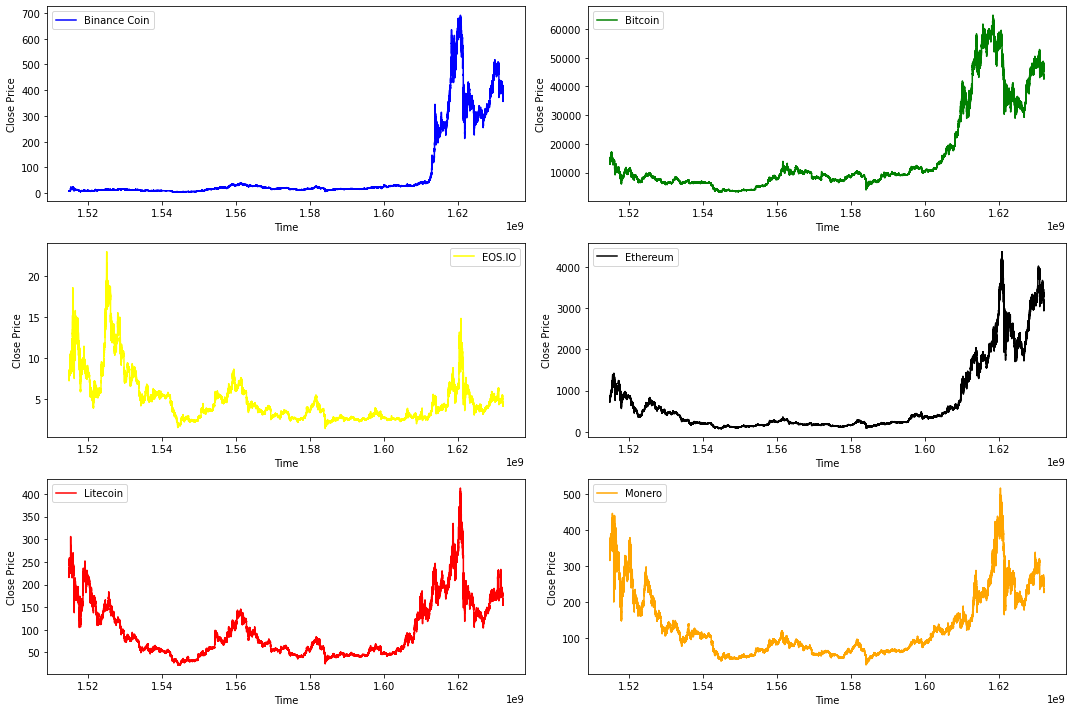

In [57]:
# visualize the close price of each cryptocurrencies from 2018-01-01
fig = plt.figure(figsize=(15,10))

fig.add_subplot(321)
plt.plot(bnc['Close'], label='Binance Coin', color="blue")
plt.legend()
plt.xlabel('Time')
plt.ylabel('Close Price')

fig.add_subplot(322)
plt.plot(bit['Close'], label='Bitcoin', color="green")
plt.legend()
plt.xlabel('Time')
plt.ylabel('Close Price')

fig.add_subplot(323)
plt.plot(eos['Close'], label='EOS.IO', color="yellow")
plt.legend()
plt.xlabel('Time')
plt.ylabel('Close Price')

fig.add_subplot(324)
plt.plot(eth['Close'], label='Ethereum', color="black")
plt.legend()
plt.xlabel('Time')
plt.ylabel('Close Price')

fig.add_subplot(325)
plt.plot(lit['Close'], label='Litecoin', color="red")
plt.legend()
plt.xlabel('Time')
plt.ylabel('Close Price')

fig.add_subplot(326)
plt.plot(mon['Close'], label='Monero', color="orange")
plt.legend()
plt.xlabel('Time')
plt.ylabel('Close Price')

plt.tight_layout()
plt.show()

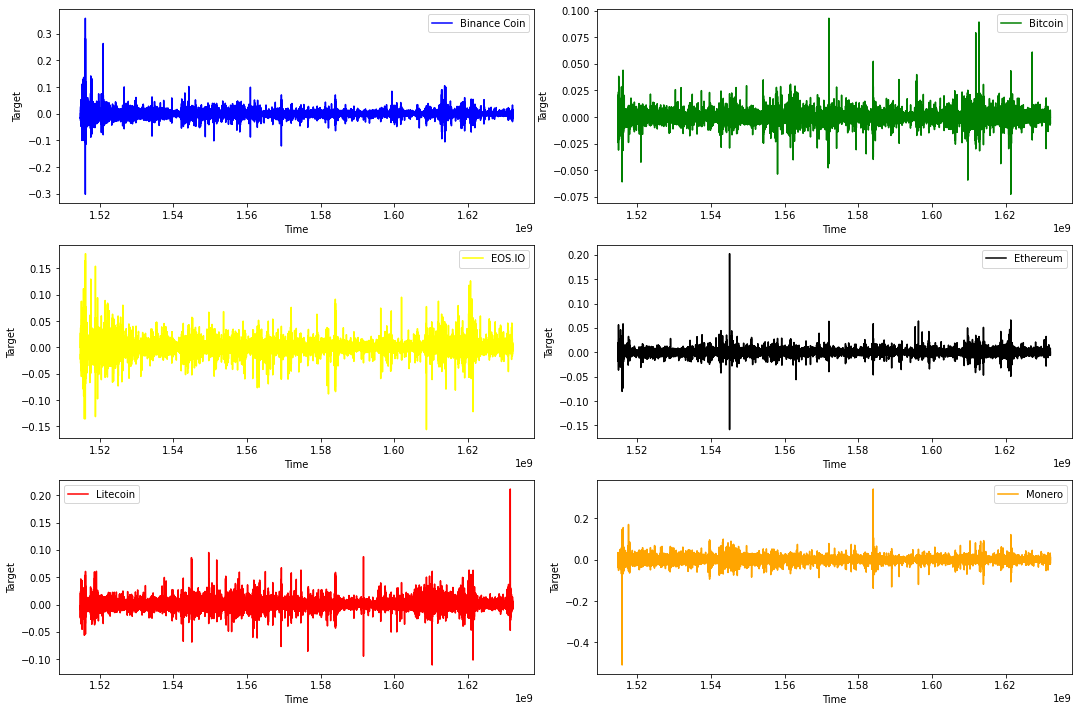

In [58]:
# visualize the target of each cryptocurrencies from 2018-01-01
fig = plt.figure(figsize=(15,10))

fig.add_subplot(321)
plt.plot(bnc['Target'], label='Binance Coin', color="blue")
plt.legend()
plt.xlabel('Time')
plt.ylabel('Target')

fig.add_subplot(322)
plt.plot(bit['Target'], label='Bitcoin', color="green")
plt.legend()
plt.xlabel('Time')
plt.ylabel('Target')

fig.add_subplot(323)
plt.plot(eos['Target'], label='EOS.IO', color="yellow")
plt.legend()
plt.xlabel('Time')
plt.ylabel('Target')

fig.add_subplot(324)
plt.plot(eth['Target'], label='Ethereum', color="black")
plt.legend()
plt.xlabel('Time')
plt.ylabel('Target')

fig.add_subplot(325)
plt.plot(lit['Target'], label='Litecoin', color="red")
plt.legend()
plt.xlabel('Time')
plt.ylabel('Target')

fig.add_subplot(326)
plt.plot(mon['Target'], label='Monero', color="orange")
plt.legend()
plt.xlabel('Time')
plt.ylabel('Target')

plt.tight_layout()
plt.show()

In [59]:
# create candlestick chart


In [60]:
df.reset_index(inplace=True)
dates = df["timestamp"].apply(lambda d: datetime.utcfromtimestamp(d).strftime('%Y-%m-%d'))
dates

0         2021-06-21
1         2021-06-21
2         2021-06-21
3         2021-06-21
4         2021-06-21
             ...    
132475    2021-09-20
132476    2021-09-20
132477    2021-09-20
132478    2021-09-20
132479    2021-09-21
Name: timestamp, Length: 132480, dtype: object

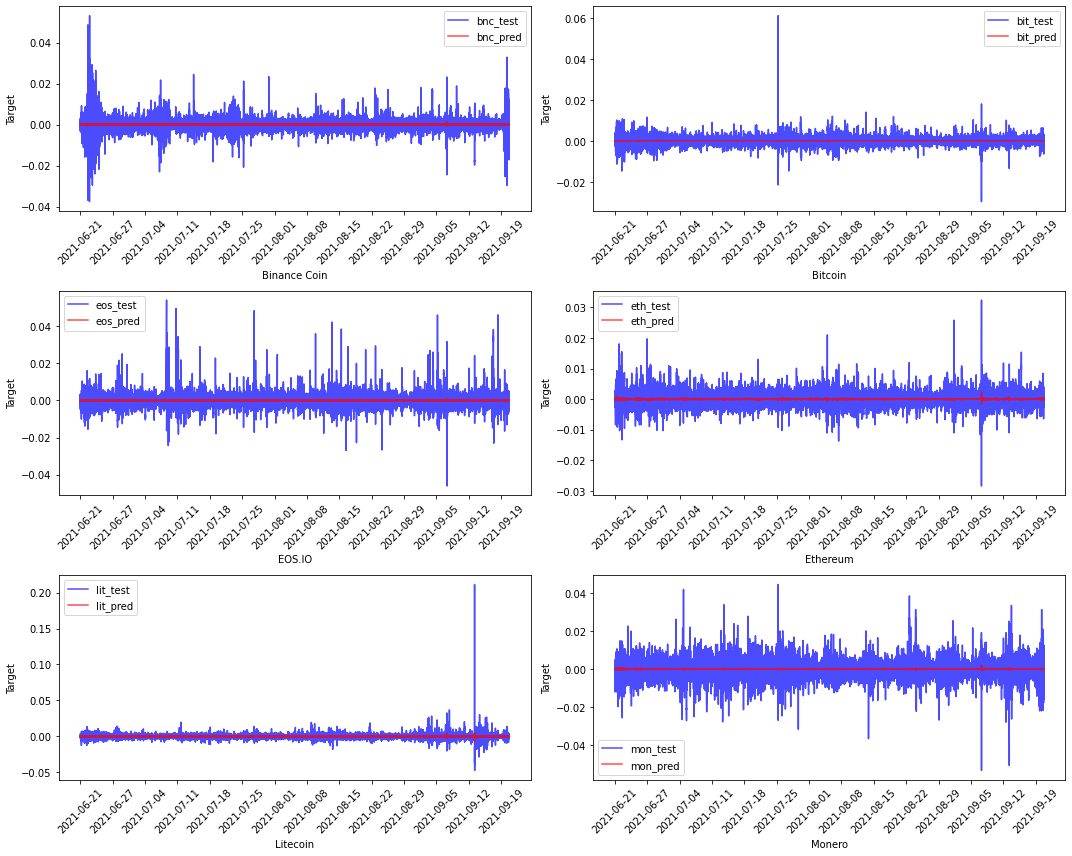

In [111]:
# visualize the prediction of lineargression vs real return for each cryptocurrency
fig = plt.figure(figsize=(15,12))
time = df["timestamp"]
fig.add_subplot(321)
plt.plot(df["timestamp"], y_bnc_test, 'b', label='bnc_test', alpha=0.7)
plt.plot(df["timestamp"], y_pred_lr_bnc, 'r', label='bnc_pred', alpha=0.7)

plt.legend()
plt.xlabel('Binance Coin')
plt.ylabel('Target')
#plt.title("Predict vs Real return for Binance Coin from 2021-06-21")
plt.xticks(time[0:-1:10000],dates[0:-1:10000], rotation = 45)

fig.add_subplot(322)
plt.plot(df["timestamp"], y_bit_test, 'b', label='bit_test', alpha=0.7)
plt.plot(df["timestamp"], y_pred_lr_bit, 'r', label='bit_pred', alpha=0.7)
plt.legend()
plt.xlabel('Bitcoin')
plt.ylabel('Target')
#plt.title("Predict vs Real return for Bitcoin from 2021-06-21")
plt.xticks(time[0:-1:10000],dates[0:-1:10000], rotation = 45)

fig.add_subplot(323)
plt.plot(df["timestamp"], y_eos_test, 'b', label='eos_test', alpha=0.7)
plt.plot(df["timestamp"], y_pred_lr_eos, 'r', label='eos_pred', alpha=0.7)
plt.legend()
plt.xlabel('EOS.IO')
plt.ylabel('Target')
#plt.title("Predict vs Real return for EOS.IO from 2021-06-21")
plt.xticks(time[0:-1:10000],dates[0:-1:10000], rotation = 45)

fig.add_subplot(324)
plt.plot(df["timestamp"], y_eth_test, 'b', label='eth_test', alpha=0.7)
plt.plot(df["timestamp"], y_pred_lr_eth, 'r', label='eth_pred', alpha=0.7)
plt.legend()
plt.xlabel('Ethereum')
plt.ylabel('Target')
#plt.title("Predict vs Real return for Ethereum from 2021-06-21")
plt.xticks(time[0:-1:10000],dates[0:-1:10000], rotation = 45)

fig.add_subplot(325)
plt.plot(df["timestamp"], y_lit_test, 'b', label='lit_test', alpha=0.7)
plt.plot(df["timestamp"], y_pred_lr_lit, 'r', label='lit_pred', alpha=0.7)
plt.legend()
plt.xlabel('Litecoin')
plt.ylabel('Target')
#plt.title("Predict vs Real return for Litecoin from 2021-06-21")
plt.xticks(time[0:-1:10000],dates[0:-1:10000], rotation = 45)

fig.add_subplot(326)
plt.plot(df["timestamp"], y_mon_test, 'b', label='mon_test', alpha=0.7)
plt.plot(df["timestamp"], y_pred_lr_mon, 'r', label='mon_pred', alpha=0.7)
plt.legend()
plt.xlabel('Monero')
plt.ylabel('Target')
#plt.title("Predict vs Real return for Monero from 2021-06-21")
plt.xticks(time[0:-1:10000],dates[0:-1:10000], rotation = 45)

plt.tight_layout()
plt.show()

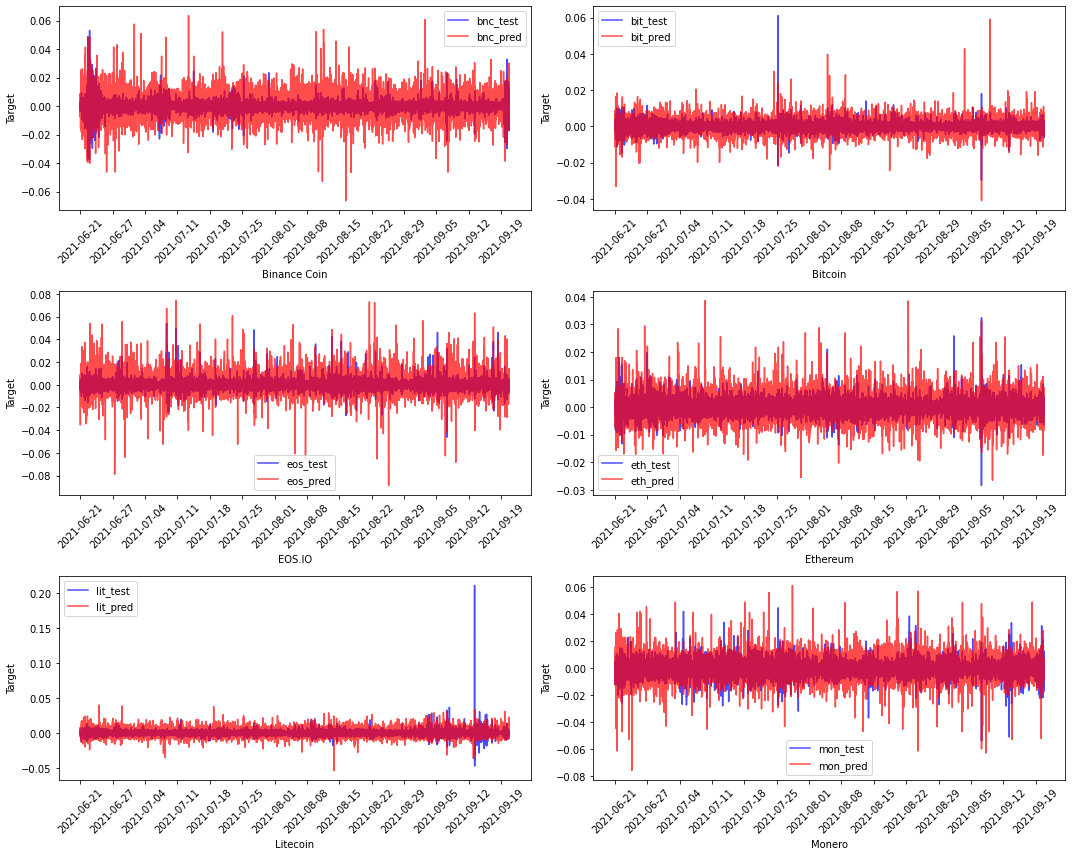

In [110]:
# visualize the prediction of randomforest vs real return for each cryptocurrency
fig = plt.figure(figsize=(15,12))
time = df["timestamp"]
fig.add_subplot(321)
plt.plot(df["timestamp"], y_bnc_test, 'b', label='bnc_test', alpha=0.7)
plt.plot(df["timestamp"], y_pred_rf_bnc, 'r', label='bnc_pred', alpha=0.7)
plt.legend()
plt.xlabel('Binance Coin')
plt.ylabel('Target')
#plt.title("Predict vs Real return for Binance Coin from 2021-06-21")
plt.xticks(time[0:-1:10000],dates[0:-1:10000], rotation = 45)

fig.add_subplot(322)
plt.plot(df["timestamp"], y_bit_test, 'b', label='bit_test', alpha=0.7)
plt.plot(df["timestamp"], y_pred_rf_bit, 'r', label='bit_pred', alpha=0.7)
plt.legend()
plt.xlabel('Bitcoin')
plt.ylabel('Target')
#plt.title("Predict vs Real return for Bitcoin from 2021-06-21")
plt.xticks(time[0:-1:10000],dates[0:-1:10000], rotation = 45)

fig.add_subplot(323)
plt.plot(df["timestamp"], y_eos_test, 'b', label='eos_test', alpha=0.7)
plt.plot(df["timestamp"], y_pred_rf_eos, 'r', label='eos_pred', alpha=0.7)
plt.legend()
plt.xlabel('EOS.IO')
plt.ylabel('Target')
#plt.title("Predict vs Real return for EOS.IO from 2021-06-21")
plt.xticks(time[0:-1:10000],dates[0:-1:10000], rotation = 45)

fig.add_subplot(324)
plt.plot(df["timestamp"], y_eth_test, 'b', label='eth_test', alpha=0.7)
plt.plot(df["timestamp"], y_pred_rf_eth, 'r', label='eth_pred', alpha=0.7)
plt.legend()
plt.xlabel('Ethereum')
plt.ylabel('Target')
#plt.title("Predict vs Real return for Ethereum from 2021-06-21")
plt.xticks(time[0:-1:10000],dates[0:-1:10000], rotation = 45)

fig.add_subplot(325)
plt.plot(df["timestamp"], y_lit_test, 'b', label='lit_test', alpha=0.7)
plt.plot(df["timestamp"], y_pred_rf_lit, 'r', label='lit_pred', alpha=0.7)
plt.legend()
plt.xlabel('Litecoin')
plt.ylabel('Target')
#plt.title("Predict vs Real return for Litecoin from 2021-06-21")
plt.xticks(time[0:-1:10000],dates[0:-1:10000], rotation = 45)

fig.add_subplot(326)
plt.plot(df["timestamp"], y_mon_test, 'b', label='mon_test', alpha=0.7)
plt.plot(df["timestamp"], y_pred_rf_mon, 'r', label='mon_pred', alpha=0.7)
plt.legend()
plt.xlabel('Monero')
plt.ylabel('Target')
#plt.title("Predict vs Real return for Monero from 2021-06-21")
plt.xticks(time[0:-1:10000],dates[0:-1:10000], rotation = 45)

plt.tight_layout()
plt.show()

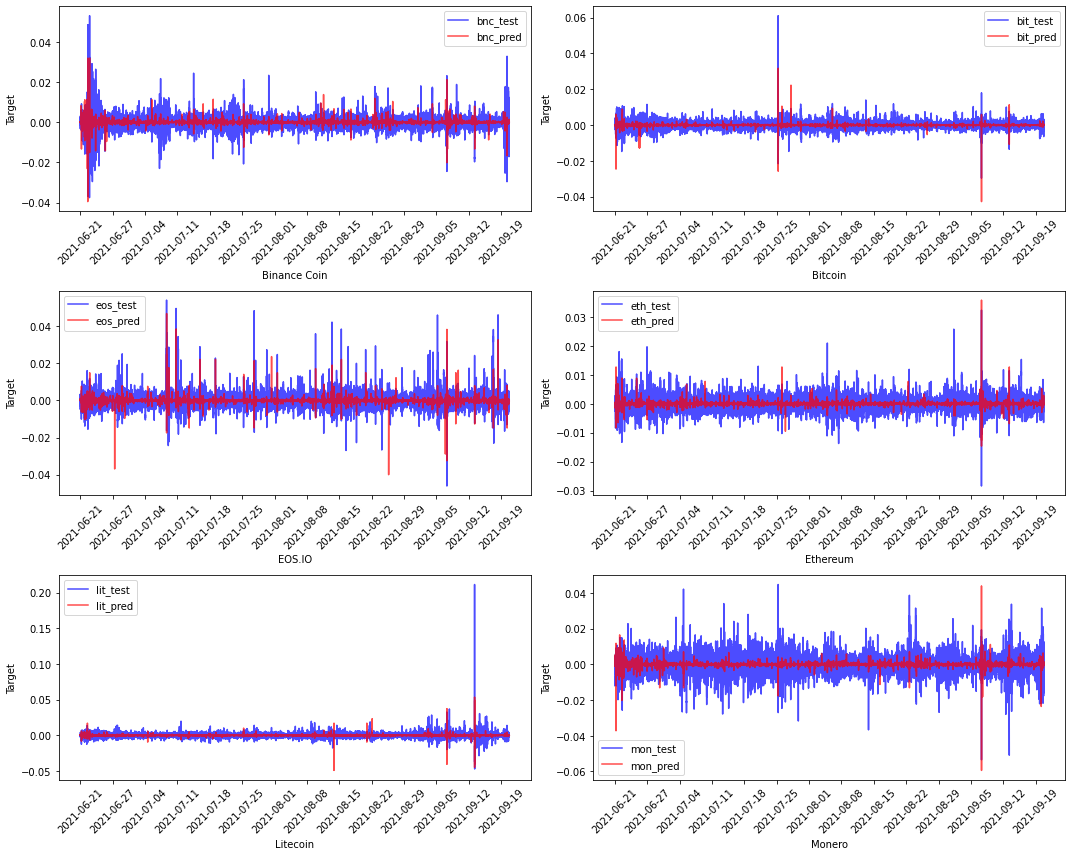

In [109]:
# visualize the prediction of xgBoost vs real return for each cryptocurrency
fig = plt.figure(figsize=(15,12))
time = df["timestamp"]
fig.add_subplot(321)
plt.plot(df["timestamp"], y_bnc_test, 'b', label='bnc_test', alpha=0.7)
plt.plot(df["timestamp"], y_pred_xg_bnc, 'r', label='bnc_pred', alpha=0.7)
plt.legend()
plt.xlabel('Binance Coin')
plt.ylabel('Target')
#plt.title("Predict vs Real return for Binance Coin from 2021-06-21")
plt.xticks(time[0:-1:10000],dates[0:-1:10000], rotation = 45)

fig.add_subplot(322)
plt.plot(df["timestamp"], y_bit_test, 'b', label='bit_test', alpha=0.7)
plt.plot(df["timestamp"], y_pred_xg_bit, 'r', label='bit_pred', alpha=0.7)
plt.legend()
plt.xlabel('Bitcoin')
plt.ylabel('Target')
#plt.title("Predict vs Real return for Bitcoin from 2021-06-21")
plt.xticks(time[0:-1:10000],dates[0:-1:10000], rotation = 45)

fig.add_subplot(323)
plt.plot(df["timestamp"], y_eos_test, 'b', label='eos_test', alpha=0.7)
plt.plot(df["timestamp"], y_pred_xg_eos, 'r', label='eos_pred', alpha=0.7)
plt.legend()
plt.xlabel('EOS.IO')
plt.ylabel('Target')
#plt.title("Predict vs Real return for EOS.IO from 2021-06-21")
plt.xticks(time[0:-1:10000],dates[0:-1:10000], rotation = 45)

fig.add_subplot(324)
plt.plot(df["timestamp"], y_eth_test, 'b', label='eth_test', alpha=0.7)
plt.plot(df["timestamp"], y_pred_xg_eth, 'r', label='eth_pred', alpha=0.7)
plt.legend()
plt.xlabel('Ethereum')
plt.ylabel('Target')
#plt.title("Predict vs Real return for Ethereum from 2021-06-21")
plt.xticks(time[0:-1:10000],dates[0:-1:10000], rotation = 45)

fig.add_subplot(325)
plt.plot(df["timestamp"], y_lit_test, 'b', label='lit_test', alpha=0.7)
plt.plot(df["timestamp"], y_pred_xg_lit, 'r', label='lit_pred', alpha=0.7)
plt.legend()
plt.xlabel('Litecoin')
plt.ylabel('Target')
#plt.title("Predict vs Real return for Litecoin from 2021-06-21")
plt.xticks(time[0:-1:10000],dates[0:-1:10000], rotation = 45)

fig.add_subplot(326)
plt.plot(df["timestamp"], y_mon_test, 'b', label='mon_test', alpha=0.7)
plt.plot(df["timestamp"], y_pred_xg_mon, 'r', label='mon_pred', alpha=0.7)
plt.legend()
plt.xlabel('Monero')
plt.ylabel('Target')
#plt.title("Predict vs Real return for Monero from 2021-06-21")
plt.xticks(time[0:-1:10000],dates[0:-1:10000], rotation = 45)

plt.tight_layout()
plt.show()

### Future price prediction

### Connect to SQL Database

In [64]:
# Connect to SQL Database

# YOUR CODE HERE